In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import tensorflow as tf
import os #for file management
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Fruit' #setting the base_dir variable to the location of the dataset containing the images

In [4]:
#now we will do some preprocessing, i.e we are preparing the raw data to make it suitable for a building and training models
IMAGE_SIZE = 224 #image size that we are going to set the images in the dataset to.
BATCH_SIZE = 32 #the number of images we are inputting into the neural network at once. was to be 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator( #preprocessing our image
    rescale = 1./255, #firstly, rescaling it to 1/255 which will make the file size smaller, hence reducing the training time
    validation_split=0.2 #secondly, normally a dataset has a test set and a training set, 
    #validation set is normally to test our neural network,which would give us a measure of accuracy on how well the neural network will do on the predictions.
    #here we are telling keras to use 20% for validation and 80% training
)

train_generator = datagen.flow_from_directory( #training generator
    base_dir, #the directory having the fruits and vegetable photos
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  #converting images to 224 by 224
    batch_size = BATCH_SIZE, #images getting inputed into the neural network through each epoch or each step
    subset='training' #the name we will call it
)
val_generator = datagen.flow_from_directory(  #validation generator
    base_dir, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)
#So as we can see from below, our training generator dataset 54191 images and the testing generator dataset has 13502 images

Found 898 images belonging to 22 classes.
Found 216 images belonging to 22 classes.


In [5]:
#Next we have to create a labels.txt file that will hold all our labels (important for Flutter)
print(train_generator.class_indices) #prints every single key and class of that dataset
labels = '\n'.join(sorted(train_generator.class_indices.keys())) #print all these keys as a list of labels into a text file called labels.txt
with open('labels.txt', 'w') as f: #writes to the labels.txt file, and if it doesnt exists, it creates one, and if it does exist, it will overrite it. (thats what 'w' is for)
    f.write(labels)

#preprocessing of raw data is hence complete and now its time to build our neural network

{'Avocado': 0, 'Banana': 1, 'Golden-Delicious': 2, 'Granny-Smith': 3, 'Kiwi': 4, 'Lemon': 5, 'Lime': 6, 'Mango': 7, 'Melon': 8, 'Nectarine': 9, 'Orange': 10, 'Papaya': 11, 'Peach': 12, 'Pear': 13, 'Pineapple': 14, 'Pink-Lady': 15, 'Plum': 16, 'Pomegranate': 17, 'Red-Delicious': 18, 'Red-Grapefruit': 19, 'Royal-Gala': 20, 'Satsumas': 21}


In [6]:
#building a neural network using transfer learning method where we take a pretrained neural network called MobileNetV2 which is a convolutional neural network architecture that seeks to perform well on mobile devices and can predict up to 80 different classes
#we are going to have a base model on top of which we are going to add pre trained neural network to have it predict the classes we want
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) 
base_model = tf.keras.applications.MobileNetV2( #grabbing pretrained neural network of choice
    input_shape=IMG_SHAPE,
    include_top=False, #this will freeze all the weights, because we dont have to retrain and change the weights, instead just add on to the MobileNetV2 CNN, so it clasiffies 5 classes instead of 80
    weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [7]:
base_model

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout


base_model.trainable=False #this freezes all the neurons for our base model
model = tf.keras.Sequential([ #neural networks act in a sequence of layers, so we add layers as we want
  base_model,
    tf.keras.layers.Conv2D(32,3, activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'), #no
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(22, activation='softmax')
 ])

model.summary()

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), #Adam is a popular optimiser, designed specifically for training deep neural networks
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [10]:
epochs = 3 #higher the epochs, more accurate is the NN, however it could cause Overfitting, if too high
history = model.fit(
    train_generator, 
    epochs = epochs, 
    validation_data=val_generator 
)

Epoch 1/3
29/29 [==============================] - 538s 18s/step - loss: 2.1634 - accuracy: 0.3831 - val_loss: 1.1807 - val_accuracy: 0.5926
Epoch 2/3
29/29 [==============================] - 6s 209ms/step - loss: 0.7751 - accuracy: 0.7695 - val_loss: 0.8530 - val_accuracy: 0.7361
Epoch 3/3
29/29 [==============================] - 6s 205ms/step - loss: 0.3758 - accuracy: 0.8898 - val_loss: 0.3854 - val_accuracy: 0.8704


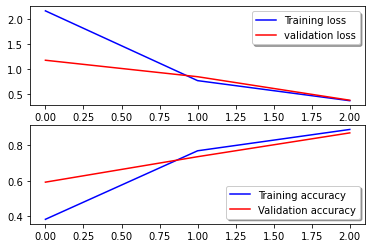

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [11]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn import svm, datasets


n_batches = len(train_generator)
X_true = np.concatenate([np.argmax(train_generator[i][1], axis=1) for i in range(n_batches)])
X_pred_class = np.argmax(model.predict(train_generator, steps=n_batches), axis=1)
n_batches = len(val_generator)
Y_true = np.concatenate([np.argmax(val_generator[i][1], axis=1) for i in range(n_batches)])
Y_pred_class = np.argmax(model.predict(val_generator, steps=n_batches), axis=1)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
  

    

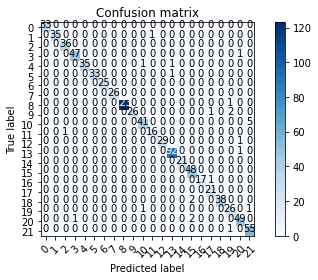

In [12]:
confusion_mtx = confusion_matrix(X_true, X_pred_class)
plot_confusion_matrix(confusion_mtx, classes = range(22))

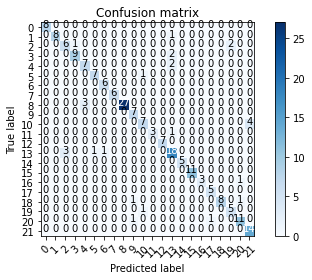

In [15]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_class) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(22))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#now that we have our neural network trained with tensorflow and keras, we can export it 
saved_model_dir = '' #means current directory
tf.saved_model.save(model, saved_model_dir) #saves to the current directory

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() #converts our model into a .tflite model which flutter uses for ondevice machine learning

with open('model.tflite', 'wb') as f: #to write the converted model into a file, written as binary so add 'wb' instead of 'w'
  f.write(tflite_model)

In [ ]:
#use below codes to download files locally if using google colab
from google.colab import files
files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>